Implementation of test of parity scaling laws in Jupyter notebook.

The code contained here is very similar to that in the rest of the repo, but is not guarenteed to be identical.

This notebook is included for ease of use.

In [1]:
# Package imports

# pip install if necessary
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install pathlib

# Standard library imports (no pip install needed)
import logging  # built-in module
import random
from pathlib import Path

# Third part imports (pip install may be required. See requirements.txt if looking to run the rest of the python project)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from datetime import datetime
import os
from typing import Tuple, Dict # if used, this should be moved to the import section

In [2]:
# Parameters

# Parameters
PARAMS = {
    'n_tasks': 1, # number of unique tasks being trained over
    'len_taskcode': 4, # number of bits in the task code
    'num_checks': 5, # number of bits in the message that are used to determine the output
    'len_message': 16, # number of bits in the message
    'num_samples': 1000, # number of samples to generate for each task, per 'epoch' (in the infinite data regime, terminology is slightly abused)
    'input_size': 20,  # len_taskcode + len_message. Used for model initialisation
    'output_size': 1, # output size of the model. 1 for binary classification. Do not change
    'learning_rate': 0.005, # constant learning rate. Could introduce a scheduler?
    'batch_size': 32, # batch size used in training. Will be the same throughout a run
    'flop_budget': 1e12, # total number of estimated flops expended per training run
    'task_sample_freq': 1e12/1e3,  # the rate at which performance is evaluated. Can give a big performance hit
    'plot_freq': 1e12/20,  # Frequency of created plots. Note that this is also the frequency at which data is saved 
    # a large plot_freq can result in significant memory consumption
    'samples_per_task': 100 # number of samples to generate for each task in evaluation
    # Note: samples_per_task is not very relevant when there is only one task, as it reproduces earlier calculations exactly
}

# Define a range of model configurations
model_configs = [
    {"num_layers": 2, "hidden_size": 8},
    {"num_layers": 4, "hidden_size": 16},
    {"num_layers": 6, "hidden_size": 32},
    {"num_layers": 8, "hidden_size": 64},
    {"num_layers": 10, "hidden_size": 128},
    {"num_layers": 12, "hidden_size": 256},
    {"num_layers": 14, "hidden_size": 512} 
]

In [3]:
# Helper functions
    
def generate_random_binary_string(length):
    # Random binary string of length 'length'
    return ''.join(random.choice(['0', '1']) for _ in range(length))

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    # Generate the task codes and their associated check bits
    unique_strings = set()
    tasks_dict = {}
    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)
        if binary_string not in unique_strings:
            unique_strings.add(binary_string)
            integer_list = [random.randint(0, len_message-1) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list
    return tasks_dict

def generate_dataset(tasks_dict, num_samples, len_taskcode, len_message):
    # Generate a dataset of num_samples samples using tasks specified in tasks_dict
    data = np.zeros((num_samples, len_taskcode + len_message))
    value = np.zeros(num_samples)
    for i in range(num_samples):
        rand_task = np.random.choice(list(tasks_dict))
        rand_checkbits = tasks_dict[rand_task]
        message = generate_random_binary_string(len_message)
        parity_bit = sum(int(message[j]) for j in rand_checkbits) % 2
        data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
        value[i] = parity_bit
    return [data, value]

def generate_dataset_for_task(task_code, tasks_dict, num_samples, len_taskcode, len_message):
    # Generate a dataset of num_samples samples for a specific task
    # Used primarily for evaluation. Very limited performance improvement from generate_dataset
    data = np.zeros((num_samples, len_taskcode + len_message))
    value = np.zeros(num_samples)
    rand_checkbits = tasks_dict[task_code]
    for i in range(num_samples):
        message = generate_random_binary_string(len_message)
        parity_bit = sum(int(message[j]) for j in rand_checkbits) % 2
        data[i] = np.concatenate((np.array(list(task_code)), np.array(list(message))))
        value[i] = parity_bit
    return [data, value]

class CustomDataset(Dataset):
    def __init__(self, dataframe, device):
        # Convert to numpy first for efficiency
        data_np = dataframe.iloc[:, :-1].values
        target_np = dataframe.iloc[:, -1].values
        
        # Single transfer to device. IO-aware for greater efficiency
        self.data = torch.from_numpy(data_np).float().to(device)
        self.target = torch.from_numpy(target_np).float().to(device)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)
        x = self.layers[-1](x)
        return x

In [4]:
# Plot intermediate progress

def plot_progress(loss_data, accuracy_data, task_accuracy_data, cumulative_flops, exp_dir, model_config):
    """
    Plot and save training progress.
    
    Args:
        loss_data: List of tuples (flops, loss)
        accuracy_data: List of tuples (flops, accuracy)
        task_accuracy_data: Dict of lists of tuples (flops, accuracy) for each task
        cumulative_flops: Current total FLOPs
        exp_dir: Path to experiment directory
        model_config: Dictionary containing model configuration
    """
    # Create model-specific subdirectories
    config_str = f"{model_config['num_layers']}x{model_config['hidden_size']}"
    plots_dir = exp_dir / "intermediate_plots" / config_str
    data_dir = exp_dir / "intermediate_data" / config_str
    plots_dir.mkdir(parents=True, exist_ok=True)
    data_dir.mkdir(parents=True, exist_ok=True)
    
    # Create figure with multiple subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot loss
    flops_loss, losses = zip(*loss_data)
    ax1.plot(flops_loss, losses)
    ax1.set_xlabel('FLOPs')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Training Loss vs FLOPs ({config_str})')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Plot overall accuracy
    flops_acc, accuracies = zip(*accuracy_data)
    ax2.plot(flops_acc, accuracies)
    ax2.set_xlabel('FLOPs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Overall Accuracy vs FLOPs ({config_str})')
    ax2.set_xscale('log')
    
    # Plot task-specific accuracies
    for task_idx, task_data in task_accuracy_data.items():
        if task_data:  # Check if there's data for this task
            flops_task, task_accuracies = zip(*task_data)
            ax3.plot(flops_task, task_accuracies, label=f'Task {task_idx}')
    ax3.set_xlabel('FLOPs')
    ax3.set_ylabel('Accuracy')
    ax3.set_title(f'Task-Specific Accuracy vs FLOPs ({config_str})')
    ax3.set_xscale('log')
    ax3.legend()
    
    # Adjust layout and save
    plt.tight_layout()
    plot_path = plots_dir / f"progress_{cumulative_flops:.2e}_flops.png"
    plt.savefig(plot_path)
    plt.close()
    
    # Log the plot creation
    logging.info(f"Saved progress plot for {config_str} at {cumulative_flops:.2e} FLOPs to {plot_path}")
    
    # Save the data as CSV
    df_metrics = pd.DataFrame({
        'flops': flops_loss,
        'loss': losses,
        'accuracy': accuracies,
        'model_config': config_str
    })
    df_metrics.to_csv(data_dir / f"metrics_{cumulative_flops:.2e}_flops.csv", index=False)
    
    # Save task-specific accuracy data
    task_data_dict = {
        'model_config': config_str,
        'flops': cumulative_flops
    }
    for task_idx, task_data in task_accuracy_data.items():
        if task_data:
            flops_task, task_accuracies = zip(*task_data)
            task_data_dict[f'task_{task_idx}_flops'] = flops_task
            task_data_dict[f'task_{task_idx}_accuracy'] = task_accuracies
    
    df_tasks = pd.DataFrame(task_data_dict)
    df_tasks.to_csv(data_dir / f"task_accuracies_{cumulative_flops:.2e}_flops.csv", index=False)

In [5]:
# Main plot

def main_plot(all_results, exp_dir):
    """
    Create final plots comparing all model configurations.
    
    Args:
        all_results: List of dictionaries containing results for each model config
        exp_dir: Path to experiment directory
    """
    # Extract data from results
    all_loss_data = []
    all_accuracy_data = []
    all_task_accuracy_data = []
    all_flops = []
    
    for result in all_results:
        all_loss_data.append(result['loss_data'])
        all_accuracy_data.append(result['accuracy_data'])
        all_task_accuracy_data.append(result['task_accuracy_data'])
        all_flops.append(result['cumulative_flops'])

    # Create final plots
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    for i, config in enumerate(model_configs):
        flops, losses = zip(*all_loss_data[i])
        plt.loglog(flops, losses, label=f'{config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Loss')
    plt.title('Loss vs FLOPs')
    plt.legend()

    # Plot overall accuracy
    plt.subplot(1, 3, 2)
    for i, config in enumerate(model_configs):
        flops, accuracies = zip(*all_accuracy_data[i])
        plt.semilogx(flops, accuracies, label=f'{config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs FLOPs')
    plt.legend()

    # Plot task-specific accuracies
    plt.subplot(1, 3, 3)
    for i, config in enumerate(model_configs):
        for task in range(PARAMS['n_tasks']):
            flops, accuracies = zip(*all_task_accuracy_data[i][task])
            plt.semilogx(flops, accuracies, 
                        label=f'Task {task+1} - {config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Task-specific Accuracy')
    plt.title('Task-specific Accuracies vs FLOPs')
    plt.legend()

    plt.tight_layout()
    
    # Save the plot
    plot_path = exp_dir / "final_comparison.png"
    plt.savefig(plot_path)
    plt.close()
    
    logging.info(f"Saved final comparison plot to {plot_path}")

In [6]:
# Count FLOPs

# No longer in use. fvcore seems to have given unreliable results, although this may down to my quite simplistic counting of flops
#def count_flops_fvcore(model, input_size):
#    input_tensor = torch.randn(2, input_size)
#    flops = FlopCountAnalysis(model, input_tensor)
#    return flops.total() // 2

class FlopCounter:
    def __init__(self, model: nn.Module, input_size: int, batch_size: int):
        self.model = model
        self.input_size = input_size
        self.batch_size = batch_size
        
    def count_linear_flops(self, in_features: int, out_features: int) -> Dict[str, int]:
        """
        Count FLOPs for linear layer operations.
        Forward: Each output element requires in_features multiplications and in_features-1 additions
        Backward: Requires computing gradients for weights, biases, and input
        """
        forward_flops = self.batch_size * out_features * (2 * in_features - 1)  # mult-add pairs
        
        # Backward pass FLOPs:
        # 1. dL/dW computation: batch_size * in_features * out_features * 2
        # 2. dL/db computation: batch_size * out_features
        # 3. dL/dx computation: batch_size * in_features * out_features * 2
        backward_flops = (
            self.batch_size * in_features * out_features * 2 +  # dL/dW
            self.batch_size * out_features +                    # dL/db
            self.batch_size * in_features * out_features * 2    # dL/dx
        )
        
        return {
            "forward": forward_flops,
            "backward": backward_flops
        }
    
    def count_batch_norm_flops(self, num_features: int) -> Dict[str, int]:
        """
        Count FLOPs for batch normalization operations.
        Forward: Computing mean, variance, normalized values, and scaling
        Backward: Computing gradients for gamma, beta, and input
        """
        # Forward pass operations per feature:
        # 1. Mean calculation: batch_size additions
        # 2. Variance calculation: batch_size multiplications and additions
        # 3. Normalization: 4 operations per element (subtract mean, divide by std)
        # 4. Scale and shift: 2 operations per element
        forward_flops = self.batch_size * num_features * (7)
        
        # Backward pass operations:
        # 1. Gradients for gamma and beta: batch_size additions per feature
        # 2. Gradients for input: ~8 operations per element
        backward_flops = self.batch_size * num_features * 10
        
        return {
            "forward": forward_flops,
            "backward": backward_flops
        }
    
    def count_relu_flops(self, num_elements: int) -> Dict[str, int]:
        """
        Count FLOPs for ReLU activation.
        Forward: One comparison per element
        Backward: One multiplication per element (gradient is 0 or 1)
        """
        forward_flops = num_elements  # One comparison per element
        backward_flops = num_elements  # One multiplication per element
        
        return {
            "forward": forward_flops,
            "backward": backward_flops
        }
    
    def calculate_total_flops(self) -> Tuple[int, int]:
        """
        Calculate total FLOPs for both forward and backward passes through the entire model.
        Returns tuple of (forward_flops, backward_flops)
        """
        total_forward_flops = 0
        total_backward_flops = 0
        
        current_size = self.input_size
        
        for layer in self.model.layers:
            if isinstance(layer, nn.Linear):
                flops = self.count_linear_flops(layer.in_features, layer.out_features)
                total_forward_flops += flops["forward"]
                total_backward_flops += flops["backward"]
                current_size = layer.out_features
                
            elif isinstance(layer, nn.BatchNorm1d):
                flops = self.count_batch_norm_flops(current_size)
                total_forward_flops += flops["forward"]
                total_backward_flops += flops["backward"]
                
            # Count ReLU FLOPs after linear layers (except the last one)
            if isinstance(layer, nn.Linear) and layer != self.model.layers[-1]:
                flops = self.count_relu_flops(self.batch_size * current_size)
                total_forward_flops += flops["forward"]
                total_backward_flops += flops["backward"]
        
        return total_forward_flops, total_backward_flops

def get_flops_per_pass(model: nn.Module, input_size: int, batch_size: int) -> Tuple[int, int]:
    """
    Wrapper function to get FLOPs per forward and backward pass.
    
    Args:
        model: PyTorch neural network model
        input_size: Size of input features
        batch_size: Batch size used in training
        
    Returns:
        Tuple of (forward_flops, backward_flops)
    """
    counter = FlopCounter(model, input_size, batch_size)
    return counter.calculate_total_flops()


In [7]:
# Managing saving of files

def create_versioned_directory(base_dir: Path, name: str) -> Path:
    """
    Create a versioned directory to avoid overwriting existing experiments.
    
    Args:
        base_dir: Base directory for experiments
        name: Base name for the experiment directory
        
    Returns:
        Path: Path to the created directory
    """
    base_dir.mkdir(exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    version = 1
    
    while True:
        versioned_name = f"{name}__{timestamp}_v{version}"
        dir_path = base_dir / versioned_name
        if not dir_path.exists():
            dir_path.mkdir()
            return dir_path
        version += 1

In [8]:
# Training loop

# This function has been significantly modified to incorporate the new count FLOPs function
# There may be bugs down the line related to how data is collected and displayed. This should be more thoroughly debugged

def train_and_evaluate(model, params, tasks_dict, exp_dir, model_config):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Initialize criterion and optimizer
    criterion = nn.BCEWithLogitsLoss() # Identical to BCE, except for application of sigmoid to the outputs. Gives smoother loss
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
    
    # Initialize FlopCounter
    flop_counter = FlopCounter(model, input_size=params['input_size'], batch_size=params['batch_size'])
    forward_flops, backward_flops = flop_counter.calculate_total_flops()
    
    loss_data = []
    accuracy_data = []
    task_accuracy_data = {i: [] for i in range(params['n_tasks'])}
    cumulative_flops = 0
    epoch = 0
    last_task_sample = 0
    last_plot = 0

    print_rate = params['flop_budget'] / 1e1 # prints only when the FLOP budget is reached
    disp_flops = 0
    
    while cumulative_flops < params['flop_budget']:
        if cumulative_flops - print_rate > disp_flops:
            print(f'cumulative_flops: {cumulative_flops} - flop_budget: {params["flop_budget"]} - Percentage completion: {(cumulative_flops/params["flop_budget"])*100:.2f}%')
            disp_flops = cumulative_flops
            
        epoch += 1
        [data, value] = generate_dataset(tasks_dict, params['num_samples'], 
                                       params['len_taskcode'], params['len_message'])
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1))
        
        dataset = CustomDataset(df, device)
        data_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
        
        epoch_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for inputs, labels in data_loader:
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels.unsqueeze(1))
            predictions = (outputs >= 0.5).squeeze().long()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            epoch_loss += batch_loss.item() * inputs.size(0)
            
            # Calculate FLOPs
            batch_flops = forward_flops + backward_flops
            cumulative_flops += batch_flops

        avg_loss = epoch_loss / len(dataset)
        avg_accuracy = correct / total

        loss_data.append((cumulative_flops, avg_loss))
        accuracy_data.append((cumulative_flops, avg_accuracy))
        
        # Task-specific evaluation
        if cumulative_flops - last_task_sample >= params['task_sample_freq'] or cumulative_flops >= params['flop_budget']:
            last_task_sample = cumulative_flops
            
            for task_idx, task_code in enumerate(tasks_dict.keys()):
                [data_per_task, value_per_task] = generate_dataset_for_task(
                    task_code, tasks_dict, params['samples_per_task'],
                    params['len_taskcode'], params['len_message']
                )
                df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1))
                dataset_per_task = CustomDataset(df_per_task, device)
                loader_per_task = DataLoader(dataset_per_task, batch_size=params['batch_size'], shuffle=True)
                
                model.eval()
                task_correct = 0
                task_total = 0
                
                with torch.no_grad():
                    for inputs, labels in loader_per_task:
                        outputs = model(inputs)
                        predictions = (outputs >= 0.5).squeeze().long()
                        task_correct += (predictions == labels).sum().item()
                        task_total += labels.size(0)
                        cumulative_flops += forward_flops
                        
                task_accuracy = task_correct / task_total
                task_accuracy_data[task_idx].append((cumulative_flops, task_accuracy))

        if cumulative_flops - last_plot >= params['plot_freq']:
            last_plot = cumulative_flops
            plot_progress(loss_data, accuracy_data, task_accuracy_data, cumulative_flops, exp_dir, model_config)

    return { # loss_data, accuracy_data, task_accuracy_data, cumulative_flops
        'loss_data': loss_data,
        'accuracy_data': accuracy_data,
        'task_accuracy_data': task_accuracy_data,
        'cumulative_flops': cumulative_flops,
        'model_config': model_config
    }

Using device: cuda
Experiment directory: experiments/parity_scaling_flops_1e+12__20250108_232600_v1
FLOP budget: 1000000000000.0
Generated tasks dictionary with 1 tasks
tasks_dict =  dict_items([('1111', [1, 11, 12, 13, 5])])


Training models:   0%|          | 0/7 [00:00<?, ?it/s]


Training model with 2 layers and hidden size 8
Using device: cuda
cumulative_flops: 100000646784 - flop_budget: 1000000000000.0 - Percentage completion: 10.00%
cumulative_flops: 200001336448 - flop_budget: 1000000000000.0 - Percentage completion: 20.00%
cumulative_flops: 300002026112 - flop_budget: 1000000000000.0 - Percentage completion: 30.00%
cumulative_flops: 400002715776 - flop_budget: 1000000000000.0 - Percentage completion: 40.00%
cumulative_flops: 500003405440 - flop_budget: 1000000000000.0 - Percentage completion: 50.00%
cumulative_flops: 600004095104 - flop_budget: 1000000000000.0 - Percentage completion: 60.00%
cumulative_flops: 700004784768 - flop_budget: 1000000000000.0 - Percentage completion: 70.00%
cumulative_flops: 800005474432 - flop_budget: 1000000000000.0 - Percentage completion: 80.00%
cumulative_flops: 900006164096 - flop_budget: 1000000000000.0 - Percentage completion: 90.00%


Training models:  14%|█▍        | 1/7 [14:56:27<89:38:47, 53787.92s/it]


Training model with 4 layers and hidden size 16
Using device: cuda
cumulative_flops: 100001287808 - flop_budget: 1000000000000.0 - Percentage completion: 10.00%
cumulative_flops: 200002821248 - flop_budget: 1000000000000.0 - Percentage completion: 20.00%
cumulative_flops: 300004354688 - flop_budget: 1000000000000.0 - Percentage completion: 30.00%
cumulative_flops: 400005642496 - flop_budget: 1000000000000.0 - Percentage completion: 40.00%
cumulative_flops: 500007175936 - flop_budget: 1000000000000.0 - Percentage completion: 50.00%
cumulative_flops: 600008709376 - flop_budget: 1000000000000.0 - Percentage completion: 60.00%
cumulative_flops: 700009997184 - flop_budget: 1000000000000.0 - Percentage completion: 70.00%
cumulative_flops: 800011530624 - flop_budget: 1000000000000.0 - Percentage completion: 80.00%
cumulative_flops: 900013064064 - flop_budget: 1000000000000.0 - Percentage completion: 90.00%


Training models:  29%|██▊       | 2/7 [19:11:48<43:16:40, 31160.11s/it]


Training model with 6 layers and hidden size 32
Using device: cuda
cumulative_flops: 100014001920 - flop_budget: 1000000000000.0 - Percentage completion: 10.00%
cumulative_flops: 200028003840 - flop_budget: 1000000000000.0 - Percentage completion: 20.00%
cumulative_flops: 300042005760 - flop_budget: 1000000000000.0 - Percentage completion: 30.00%
cumulative_flops: 400056007680 - flop_budget: 1000000000000.0 - Percentage completion: 40.01%
cumulative_flops: 500070009600 - flop_budget: 1000000000000.0 - Percentage completion: 50.01%
cumulative_flops: 600084011520 - flop_budget: 1000000000000.0 - Percentage completion: 60.01%
cumulative_flops: 700098013440 - flop_budget: 1000000000000.0 - Percentage completion: 70.01%
cumulative_flops: 800112015360 - flop_budget: 1000000000000.0 - Percentage completion: 80.01%
cumulative_flops: 900126017280 - flop_budget: 1000000000000.0 - Percentage completion: 90.01%


Training models:  43%|████▎     | 3/7 [20:14:03<20:42:29, 18637.26s/it]


Training model with 8 layers and hidden size 64
Using device: cuda
cumulative_flops: 100136341120 - flop_budget: 1000000000000.0 - Percentage completion: 10.01%
cumulative_flops: 200272682240 - flop_budget: 1000000000000.0 - Percentage completion: 20.03%
cumulative_flops: 300416002816 - flop_budget: 1000000000000.0 - Percentage completion: 30.04%
cumulative_flops: 400552343936 - flop_budget: 1000000000000.0 - Percentage completion: 40.06%
cumulative_flops: 500688685056 - flop_budget: 1000000000000.0 - Percentage completion: 50.07%
cumulative_flops: 600832005632 - flop_budget: 1000000000000.0 - Percentage completion: 60.08%
cumulative_flops: 700968346752 - flop_budget: 1000000000000.0 - Percentage completion: 70.10%
cumulative_flops: 801104687872 - flop_budget: 1000000000000.0 - Percentage completion: 80.11%
cumulative_flops: 901248008448 - flop_budget: 1000000000000.0 - Percentage completion: 90.12%


Training models:  57%|█████▋    | 4/7 [20:28:57<9:41:36, 11632.23s/it] 


Training model with 10 layers and hidden size 128
Using device: cuda
cumulative_flops: 100554040064 - flop_budget: 1000000000000.0 - Percentage completion: 10.06%
cumulative_flops: 201143240064 - flop_budget: 1000000000000.0 - Percentage completion: 20.11%
cumulative_flops: 301697280128 - flop_budget: 1000000000000.0 - Percentage completion: 30.17%
cumulative_flops: 402286480128 - flop_budget: 1000000000000.0 - Percentage completion: 40.23%
cumulative_flops: 502840520192 - flop_budget: 1000000000000.0 - Percentage completion: 50.28%
cumulative_flops: 603429720192 - flop_budget: 1000000000000.0 - Percentage completion: 60.34%
cumulative_flops: 703983760256 - flop_budget: 1000000000000.0 - Percentage completion: 70.40%
cumulative_flops: 804572960256 - flop_budget: 1000000000000.0 - Percentage completion: 80.46%
cumulative_flops: 905127000320 - flop_budget: 1000000000000.0 - Percentage completion: 90.51%


Training models:  71%|███████▏  | 5/7 [20:32:36<4:10:33, 7516.63s/it] 


Training model with 12 layers and hidden size 256
Using device: cuda
cumulative_flops: 102752056320 - flop_budget: 1000000000000.0 - Percentage completion: 10.28%
cumulative_flops: 205504112640 - flop_budget: 1000000000000.0 - Percentage completion: 20.55%
cumulative_flops: 308256168960 - flop_budget: 1000000000000.0 - Percentage completion: 30.83%
cumulative_flops: 411008225280 - flop_budget: 1000000000000.0 - Percentage completion: 41.10%
cumulative_flops: 513760281600 - flop_budget: 1000000000000.0 - Percentage completion: 51.38%
cumulative_flops: 616512337920 - flop_budget: 1000000000000.0 - Percentage completion: 61.65%
cumulative_flops: 719264394240 - flop_budget: 1000000000000.0 - Percentage completion: 71.93%
cumulative_flops: 822016450560 - flop_budget: 1000000000000.0 - Percentage completion: 82.20%
cumulative_flops: 924768506880 - flop_budget: 1000000000000.0 - Percentage completion: 92.48%


Training models:  86%|████████▌ | 6/7 [20:33:35<1:23:01, 4981.14s/it]


Training model with 14 layers and hidden size 512
Using device: cuda
cumulative_flops: 101637815680 - flop_budget: 1000000000000.0 - Percentage completion: 10.16%
cumulative_flops: 203275631360 - flop_budget: 1000000000000.0 - Percentage completion: 20.33%
cumulative_flops: 304913447040 - flop_budget: 1000000000000.0 - Percentage completion: 30.49%
cumulative_flops: 406551262720 - flop_budget: 1000000000000.0 - Percentage completion: 40.66%
cumulative_flops: 508189078400 - flop_budget: 1000000000000.0 - Percentage completion: 50.82%
cumulative_flops: 609826894080 - flop_budget: 1000000000000.0 - Percentage completion: 60.98%
cumulative_flops: 711464709760 - flop_budget: 1000000000000.0 - Percentage completion: 71.15%
cumulative_flops: 813102525440 - flop_budget: 1000000000000.0 - Percentage completion: 81.31%
cumulative_flops: 914740341120 - flop_budget: 1000000000000.0 - Percentage completion: 91.47%


Training models: 100%|██████████| 7/7 [20:33:53<00:00, 10576.26s/it] 


NameError: name 'MODEL_CONFIGS' is not defined

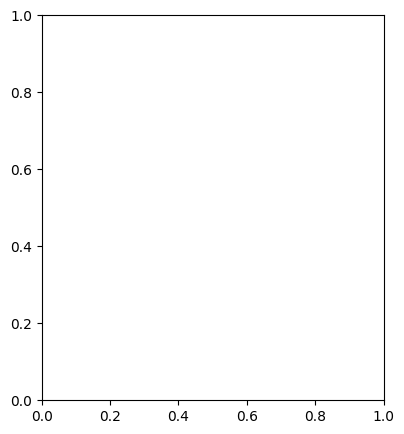

In [9]:
# Main

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create experiment directory
    exp_name = f"parity_scaling_flops_{PARAMS['flop_budget']:.0e}"
    exp_dir = create_versioned_directory(Path("experiments"), exp_name)
    print(f"Experiment directory: {exp_dir}")

    print(f"FLOP budget: {PARAMS['flop_budget']}")
    
    tasks_dict = generate_dict(
        PARAMS['n_tasks'], 
        PARAMS['len_taskcode'], 
        PARAMS['num_checks'], 
        PARAMS['len_message']
    )
    print(f"Generated tasks dictionary with {len(tasks_dict)} tasks")
    print("tasks_dict = ", tasks_dict.items())
    
    all_results = []
    
    # Add progress bar for model configurations
    for config in tqdm(model_configs, desc="Training models", position=0, leave=True):
        print(f"\nTraining model with {config['num_layers']} layers and hidden size {config['hidden_size']}")
        model = NeuralNetwork(
            PARAMS['input_size'], 
            PARAMS['output_size'], 
            config["num_layers"], 
            config["hidden_size"]
        ).to(device)
        # model, criterion, optimizer, flop_budget, tasks_dict
        results = train_and_evaluate(
            model=model,
            params=PARAMS,
            tasks_dict=tasks_dict,
            exp_dir=exp_dir,
            model_config=config
        )
        all_results.append(results)
    
    # Create final plots
    main_plot(all_results, exp_dir)

if __name__ == '__main__':
    main()

In [ ]:
def create_seaborn_plots(exp_dir: Path, epoch_window: int = 10, confidence_interval: float = 0.95):
    """Create seaborn plots from saved data across all model configurations."""
    # Set up logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    # Directory setup and validation
    if isinstance(exp_dir, str):
        exp_dir = Path("experiments") / exp_dir
    elif isinstance(exp_dir, Path):
        exp_dir = Path("experiments") / exp_dir.name
    
    exp_dir = exp_dir.absolute()
    logger.info(f"Looking for data in: {exp_dir}")
    
    # Create seaborn plots directory
    seaborn_dir = exp_dir / "seaborn_plots"
    seaborn_dir.mkdir(exist_ok=True)
    logger.info(f"Created seaborn plots directory: {seaborn_dir}")
    
    # Initialize lists to store all data
    all_metrics = []
    all_task_data = []
    
    # Iterate through model configuration directories
    data_dir = exp_dir / "intermediate_data"
    model_dirs = list(data_dir.glob("*x*"))
    logger.info(f"Found {len(model_dirs)} model configuration directories")
    
    for model_dir in model_dirs:
        config_str = model_dir.name
        logger.info(f"Processing data for model configuration: {config_str}")
        
        # Get metrics files for this configuration
        metrics_files = sorted(model_dir.glob("metrics_*.csv"))
        logger.info(f"Found {len(metrics_files)} metrics files for {config_str}")
        
        for file in metrics_files:
            try:
                df = pd.read_csv(file)
                df['model_config'] = config_str
                all_metrics.append(df)
                logger.debug(f"Processed metrics file: {file.name}")
            except Exception as e:
                logger.error(f"Error processing metrics file {file}: {e}")
        
        # Get task accuracy files
        task_files = sorted(model_dir.glob("task_accuracies_*.csv"))
        logger.info(f"Found {len(task_files)} task accuracy files for {config_str}")
        
        for file in task_files:
            try:
                df = pd.read_csv(file)
                task_cols = [col for col in df.columns if 'task' in col]
                for i in range(0, len(task_cols), 2):
                    flops_col = task_cols[i]
                    acc_col = task_cols[i+1]
                    task_num = flops_col.split('_')[1]
                    
                    task_df = pd.DataFrame({
                        'flops': df[flops_col],
                        'accuracy': df[acc_col],
                        'task': f'Task {task_num}',
                        'model_config': config_str
                    })
                    all_task_data.append(task_df)
                logger.debug(f"Processed task file: {file.name}")
            except Exception as e:
                logger.error(f"Error processing task file {file}: {e}")
    
    # Check if we have data to plot
    if not all_metrics:
        logger.error("No metrics data found")
        return
    
    logger.info(f"Combining {len(all_metrics)} metric dataframes")
    metrics_df = pd.concat(all_metrics, ignore_index=True)
    logger.info(f"Combined metrics shape: {metrics_df.shape}")
    
    # Create epoch bins
    try:
        metrics_df['epoch_bin'] = pd.qcut(metrics_df['flops'], 
                                        q=len(metrics_df)//epoch_window, 
                                        labels=False,
                                        duplicates='drop')
        logger.info("Created epoch bins for metrics")
    except Exception as e:
        logger.error(f"Error creating epoch bins for metrics: {e}")
        return
    
    # Combine task data if available
    if all_task_data:
        logger.info(f"Combining {len(all_task_data)} task dataframes")
        task_df = pd.concat(all_task_data, ignore_index=True)
        logger.info(f"Combined task data shape: {task_df.shape}")
        
        try:
            task_df['epoch_bin'] = pd.qcut(task_df['flops'], 
                                         q=len(task_df)//epoch_window, 
                                         labels=False,
                                         duplicates='drop')
        except Exception as e:
            logger.warning(f"Error creating epoch bins for tasks: {e}")
    
    # Create plots
    logger.info("Creating plots")
    try:
        sns.set_style("whitegrid")
        sns.set_palette("husl")
        
        # Create and save each plot separately
        # 1. Loss plot
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=metrics_df, 
                    x='flops', 
                    y='loss',
                    hue='model_config',
                    errorbar=('ci', confidence_interval))
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Training Loss vs FLOPs')
        loss_path = seaborn_dir / f"loss_plot_window{epoch_window}.png"
        plt.savefig(loss_path, bbox_inches='tight')
        plt.close()
        logger.info(f"Saved loss plot to {loss_path}")
        
        # 2. Accuracy plot
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=metrics_df, 
                    x='flops', 
                    y='accuracy',
                    hue='model_config',
                    errorbar=('ci', confidence_interval))
        plt.xscale('log')
        plt.title('Overall Accuracy vs FLOPs')
        acc_path = seaborn_dir / f"accuracy_plot_window{epoch_window}.png"
        plt.savefig(acc_path, bbox_inches='tight')
        plt.close()
        logger.info(f"Saved accuracy plot to {acc_path}")
        
        # 3. Task-specific plot
        if all_task_data:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=task_df, 
                        x='flops', 
                        y='accuracy',
                        hue='task',
                        style='model_config',
                        errorbar=('ci', confidence_interval))
            plt.xscale('log')
            plt.title('Task-Specific Accuracy vs FLOPs')
            task_path = seaborn_dir / f"task_accuracy_plot_window{epoch_window}.png"
            plt.savefig(task_path, bbox_inches='tight')
            plt.close()
            logger.info(f"Saved task-specific plot to {task_path}")
        
    except Exception as e:
        logger.error(f"Error creating plots: {e}")
        raise
    
    logger.info("Finished creating all plots")

# Example usage
exp_dir = Path('/experiments/parity_scaling_flops_1e+12__20250108_232600_v1')
# When calling the function
#print(f"Original exp_dir: {exp_dir}")
#print(f"Absolute exp_dir: {exp_dir.resolve()}")
create_seaborn_plots(exp_dir.resolve(), epoch_window = 100) # untested

In [14]:
def create_plots_from_saved_data(exp_dir: str | Path, model_configs=model_configs):
    """
    Create plots from saved data in experiment directory.
    
    Args:
        exp_dir: Path to experiment directory (can be string or Path)
        model_configs: List of model configurations (defaults to MODEL_CONFIGS)
    """
    # Convert string to Path if necessary
    if isinstance(exp_dir, str):
        exp_dir = Path("experiments") / exp_dir
    elif isinstance(exp_dir, Path):
        exp_dir = Path("experiments") / exp_dir.name
    
    exp_dir = exp_dir.absolute()
    print(f"Looking for data in: {exp_dir}")
    
    # Create plots directory
    plots_dir = exp_dir / "analysis_plots"
    plots_dir.mkdir(exist_ok=True)
    
    # Initialize data storage
    all_loss_data = []
    all_accuracy_data = []
    all_task_accuracy_data = []
    
    # Process each model configuration
    for config in model_configs:
        config_str = f"{config['num_layers']}x{config['hidden_size']}"
        print(f"\nProcessing configuration: {config_str}")
        
        # Get data directory for this configuration
        config_data_dir = exp_dir / "intermediate_data" / config_str
        if not config_data_dir.exists():
            print(f"No data directory found for configuration {config_str}")
            continue
            
        # Read metrics files
        metrics_files = sorted(config_data_dir.glob("metrics_*.csv"))
        if not metrics_files:
            print(f"No metrics files found for configuration {config_str}")
            continue
            
        # Combine all metrics data for this configuration
        config_metrics = []
        for file in metrics_files:
            df = pd.read_csv(file)
            config_metrics.append(df)
        
        if config_metrics:
            metrics_df = pd.concat(config_metrics, ignore_index=True)
            metrics_df = metrics_df.sort_values('flops')
            
            # Store loss and accuracy data
            all_loss_data.append((metrics_df['flops'].values, metrics_df['loss'].values))
            all_accuracy_data.append((metrics_df['flops'].values, metrics_df['accuracy'].values))
            
            # Process task accuracy data
            task_files = sorted(config_data_dir.glob("task_accuracies_*.csv"))
            task_data_dict = {}
            
            for file in task_files:
                df = pd.read_csv(file)
                task_cols = [col for col in df.columns if 'task' in col]
                for i in range(0, len(task_cols), 2):
                    task_idx = int(task_cols[i].split('_')[1])
                    if task_idx not in task_data_dict:
                        task_data_dict[task_idx] = []
                    
                    flops = df[task_cols[i]].values
                    accuracies = df[task_cols[i+1]].values
                    task_data_dict[task_idx].extend(list(zip(flops, accuracies)))
            
            # Sort task data by FLOPs
            for task_idx in task_data_dict:
                task_data_dict[task_idx] = sorted(task_data_dict[task_idx], key=lambda x: x[0])
            
            all_task_accuracy_data.append(task_data_dict)
    
    # Create plots
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    for i, config in enumerate(model_configs):
        if i < len(all_loss_data):
            flops, losses = all_loss_data[i]
            plt.loglog(flops, losses, label=f'{config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Loss')
    plt.title('Loss vs FLOPs')
    plt.legend()
    
    # Plot overall accuracy
    plt.subplot(1, 3, 2)
    for i, config in enumerate(model_configs):
        if i < len(all_accuracy_data):
            flops, accuracies = all_accuracy_data[i]
            plt.semilogx(flops, accuracies, label=f'{config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs FLOPs')
    plt.legend()
    
    # Plot task-specific accuracies
    plt.subplot(1, 3, 3)
    for i, config in enumerate(model_configs):
        if i < len(all_task_accuracy_data):
            task_dict = all_task_accuracy_data[i]
            for task_idx in task_dict:
                flops, accuracies = zip(*task_dict[task_idx])
                plt.semilogx(flops, accuracies, 
                           label=f'Task {task_idx} - {config["num_layers"]}x{config["hidden_size"]}')
    plt.xlabel('Cumulative FLOPs')
    plt.ylabel('Task-specific Accuracy')
    plt.title('Task-specific Accuracies vs FLOPs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Save the plot
    plot_path = plots_dir / "analysis_comparison.png"
    plt.savefig(plot_path, bbox_inches='tight')
    plt.close()
    
    print(f"Saved analysis plot to {plot_path}")

# Example usage:
exp_dir = Path('/experiments/parity_scaling_flops_1e+12__20250108_232600_v1')
# When calling the function
#print(f"Original exp_dir: {exp_dir}")
#print(f"Absolute exp_dir: {exp_dir.resolve()}")
create_plots_from_saved_data(exp_dir.resolve()) # untested

Looking for data in: /workspace/project/experiments/parity_scaling_flops_1e+12__20250108_232600_v1

Processing configuration: 2x8

Processing configuration: 4x16

Processing configuration: 6x32

Processing configuration: 8x64

Processing configuration: 10x128

Processing configuration: 12x256

Processing configuration: 14x512


/tmp/ipykernel_43785/2895696578.py:119: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_43785/2895696578.py:123: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plot_path, bbox_inches='tight')


Saved analysis plot to /workspace/project/experiments/parity_scaling_flops_1e+12__20250108_232600_v1/analysis_plots/analysis_comparison.png
